In [1]:
import os
import pickle
import pandas as pd
import time
import h5py
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw
import numpy as np
# os.environ['PATH'] = 'C:\\Users\\D\\openslide-win64-20171122\\bin' +';' + os.environ['PATH']

import openslide

In [2]:
class MILNetwork(nn.Module):
    def __init__(self , embeddeing_model , bag_size , batch_size , classes):
        super(MILNetwork, self).__init__()
        self.bag_size = bag_size
        self.batch_size = batch_size
        self.embedder = embeddeing_model
        self.fc1 = nn.Linear(1024, classes)
        self.attention =    nn.Sequential(
                            nn.Conv1d(1024,256,1),
                            nn.Tanh(),
                            nn.Conv1d(256,1,1))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        self.eval()
        out = torch.empty(size=(self.batch_size, 1024, self.bag_size)).cuda()
        for i in range(x.shape[0]):
            x_ = self.embedder.forward(x[i])
            x_ = x_.view(-1,1024)
            out[i] = x_.permute(1,0)
        A = self.attention(out)
        A = F.softmax(A , dim =2)
        M = torch.bmm(A, torch.transpose(out , 2, 1))
        M = M.view(-1, 1024)
        out = self.fc1(M)
        return out
    
    def get_attention_weights(self, x):
        self.eval()
        x = x.unsqueeze(0).cuda()
        out = torch.empty(size=(self.batch_size, 1024, self.bag_size)).cuda()
        for i in range(x.shape[0]):
            x_ = self.embedder.forward(x[i])
            x_ = x_.view(-1,1024)
            out[i] = x_.permute(1,0)
        A = self.attention(out)
        A = F.softmax(A , dim =2)
        return A.detach().cpu().numpy()
    
    def predict(self , image):
        self.eval()
        output = self.forward(image.unsqueeze(0).cuda())
        return self.softmax(output).detach().cpu().numpy()

In [4]:
AlexNet = models.alexnet().features
AlexNet = AlexNet.cuda()
MIL = MILNetwork(AlexNet , 100 , 1 , 4).cuda()
MIL.load_state_dict(torch.load('Trained MIL-Att Model - PCAM pretrained Embedding model.pt'))

<All keys matched successfully>

In [5]:
totensor = transforms.ToTensor()
toPIL = transforms.ToPILImage()
# Resizing patches and applying PCAM normalization parameters
transform = transforms.Compose([transforms.Resize(96), transforms.ToTensor(),transforms.Normalize(mean=[1.0294, 0.5995, 1.3757], std=[0.8379, 1.0470, 0.8024])])

In [6]:
MIL

MILNetwork(
  (embedder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=4, bias=True)
  (attention): Sequential(
    (0): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(25

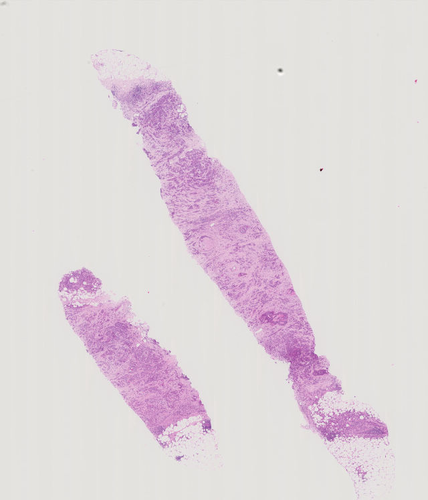

In [7]:
s = '55'
img_HE = openslide.OpenSlide('D:/Datasets - Warwick/HER2 Contest Data/Data/'+s+'/'+s+'_HE.ndpi')
img_HE.get_thumbnail((500,500))

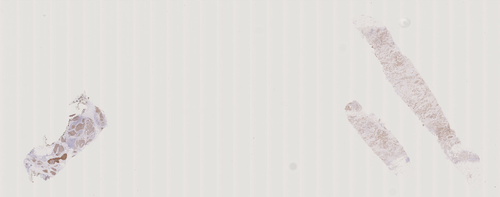

In [8]:
img_IHC = openslide.OpenSlide('D:/Datasets - Warwick/HER2 Contest Data/Data/'+s+'/'+s+'_HER2.ndpi')
img_IHC.get_thumbnail((500,500))

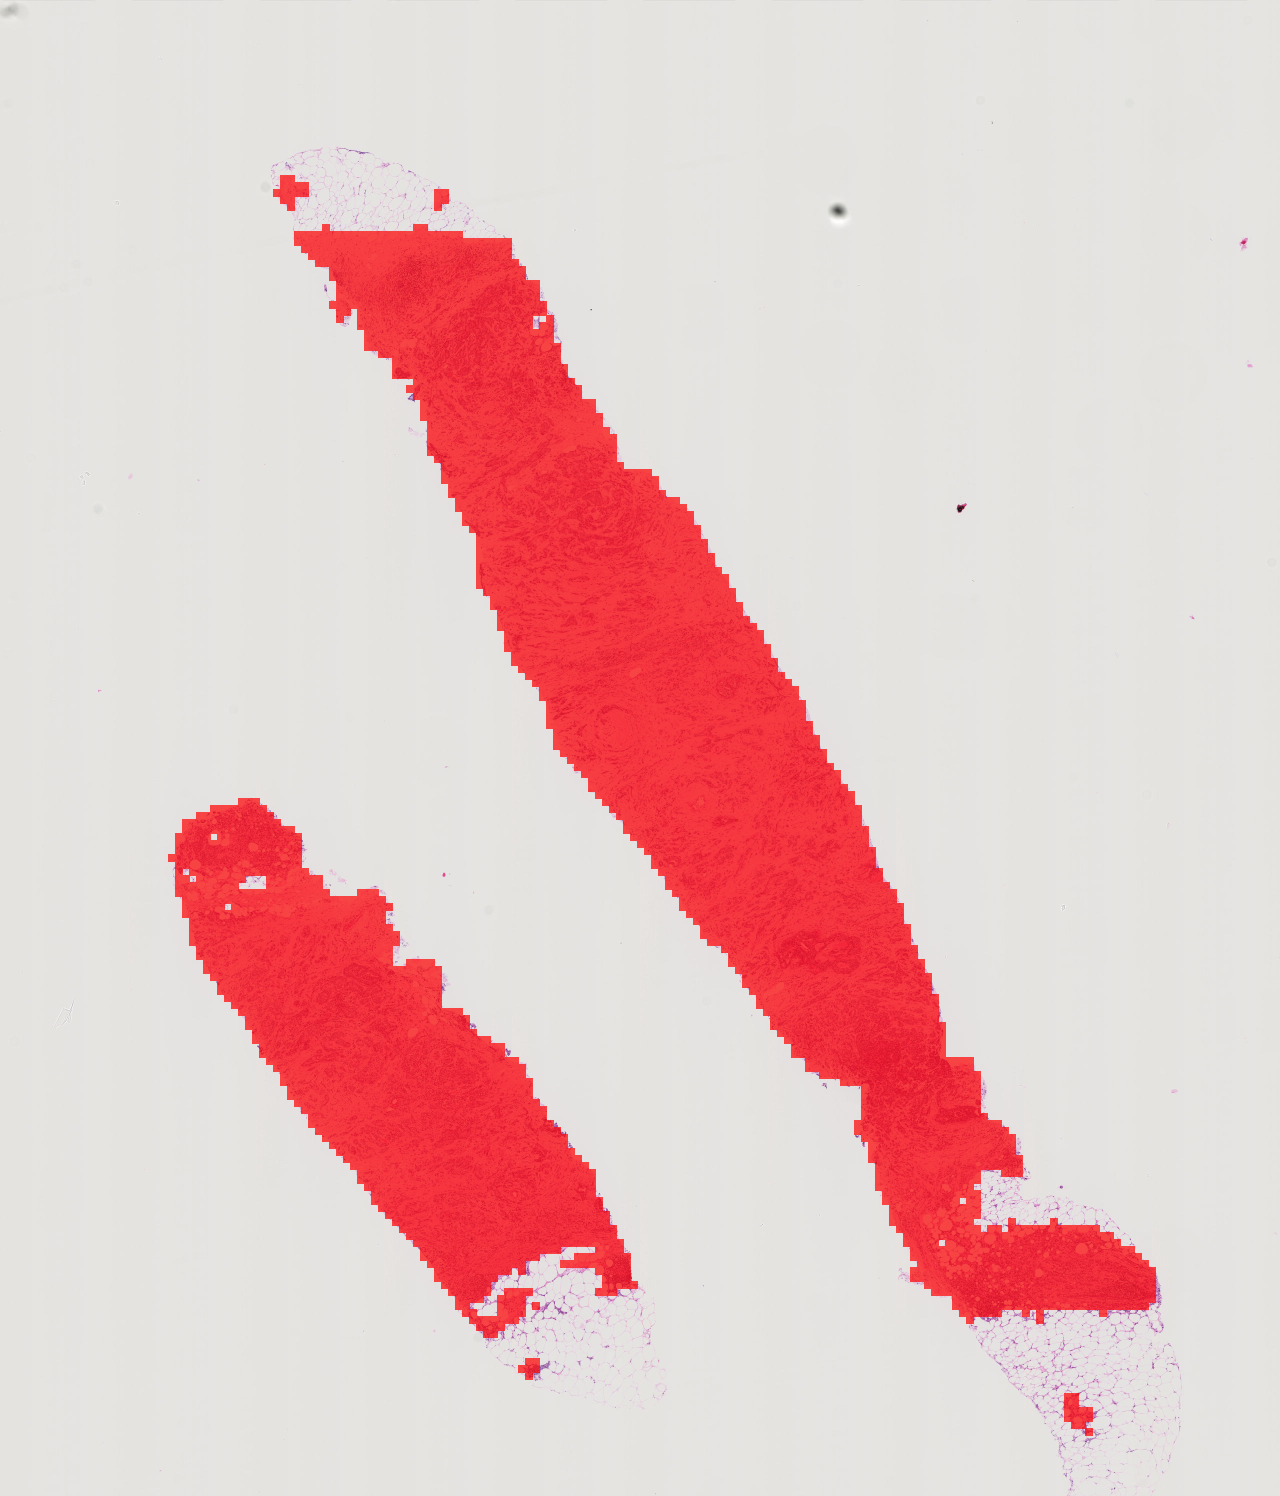

In [9]:
l = 5
HE_slide = img_HE.read_region((0, 0),l,img_HE.level_dimensions[l])
frac = int(img_HE.level_downsamples[l])
step = int(224/frac)

TRANSPARENCY = 0.7
overlay = Image.new('RGBA', HE_slide.size, (0,0,0)+(0,))
draw = ImageDraw.Draw(overlay)

coordinates = {}
SLpreds = []
itr = 0
while itr < 1000:
    itr +=1
    bag = []
    x_tesnor_bag = torch.empty(size=(100, 3, 96, 96))
    xs , ys = [], []
    while len(bag) < 100:
        x = np.random.choice(range(int(HE_slide.size[0]*(0)) , int(HE_slide.size[0]*(1)), step))
        y = np.random.choice(range(int(HE_slide.size[1]*(0)) , int(HE_slide.size[1]*(1)) , step))
        if (x in xs) and (y in ys):
            continue
        patch_img = img_HE.read_region((x*frac,y*frac),1,(step*frac,step*frac))
        patch_hue = totensor(patch_img.convert(mode='HSV'))[0]
        patch_sat = totensor(patch_img.convert(mode='HSV'))[1]
        if (torch.median(patch_hue) > 0.3) and (torch.std(patch_hue) > 0.15) or (torch.median(patch_hue) > 0.7) : #filtering the patches
            if (torch.std(patch_sat) > 0.03):
                draw.rectangle(((x, y), (x+step, y+step)), fill=(int(255),0, 0)+(int(255*TRANSPARENCY),))
                bag.append(patch_img)
                xs.append(x)
                ys.append(y)
    for i in range(len(bag)):
        x_tesnor_bag[i] = transform(bag[i].convert(mode='RGB'))
    output = MIL.predict(x_tesnor_bag)
    att = MIL.get_attention_weights(x_tesnor_bag)
    prob = output[0,2]+output[0,3]
    SLpreds.extend([prob])
                
    for i in range(len(xs)):
        x_ , y_ , at = xs[i] , ys[i], att[0,0][i]
        if (x_,y_) in coordinates.keys():
            pr = coordinates[(x_,y_)]
            pr.extend([prob.copy()*at])
            coordinates.update({(x_,y_) : pr})
        else:
            coordinates.update({(x_,y_):[prob.copy()*at]})


img = Image.alpha_composite(HE_slide, overlay)
img = img.convert("RGB")
img         

The above image is just to show the areas covered by the sampling process.

In [11]:
np.mean(SLpreds,axis=0),  np.median(SLpreds,axis=0)

(0.49990496, 0.4693709)

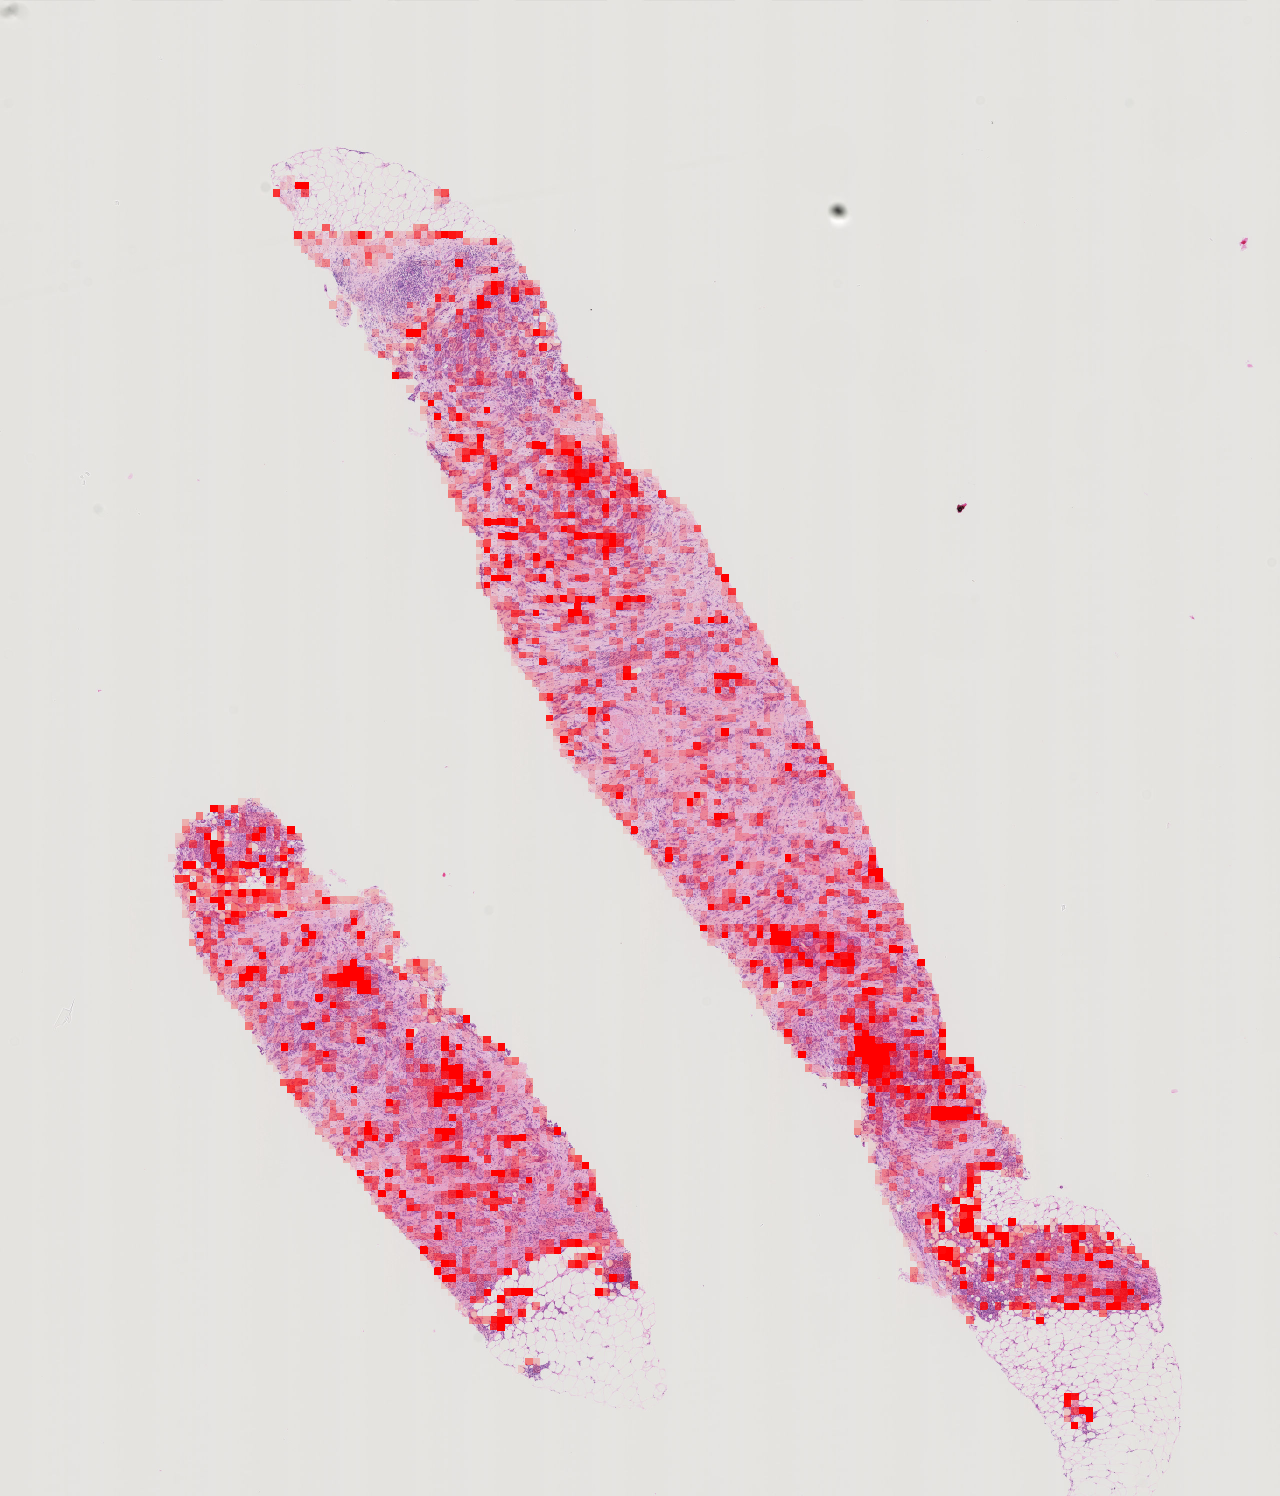

In [21]:
l = 5
HE_slide = img_HE.read_region((0, 0),l,img_HE.level_dimensions[l])
frac = int(img_HE.level_downsamples[l])
step = int(224/frac)
# max_selection = np.max([len(x) for x in list(coordinates.values())]) 

TRANSPARENCY = 0.6
overlay = Image.new('RGBA', HE_slide.size, (0,0,0)+(0,))
draw = ImageDraw.Draw(overlay)

for x , y in list(coordinates.keys()):
    plist = coordinates[(x, y)]
#     p = np.sum(plist)/max_selection
    p = np.mean(plist)*100
    draw.rectangle(((x, y), (x+step, y+step)), fill=(255,0,0)+(int(255*TRANSPARENCY*p),))

img = Image.alpha_composite(HE_slide, overlay)
img = img.convert("RGB")
img         

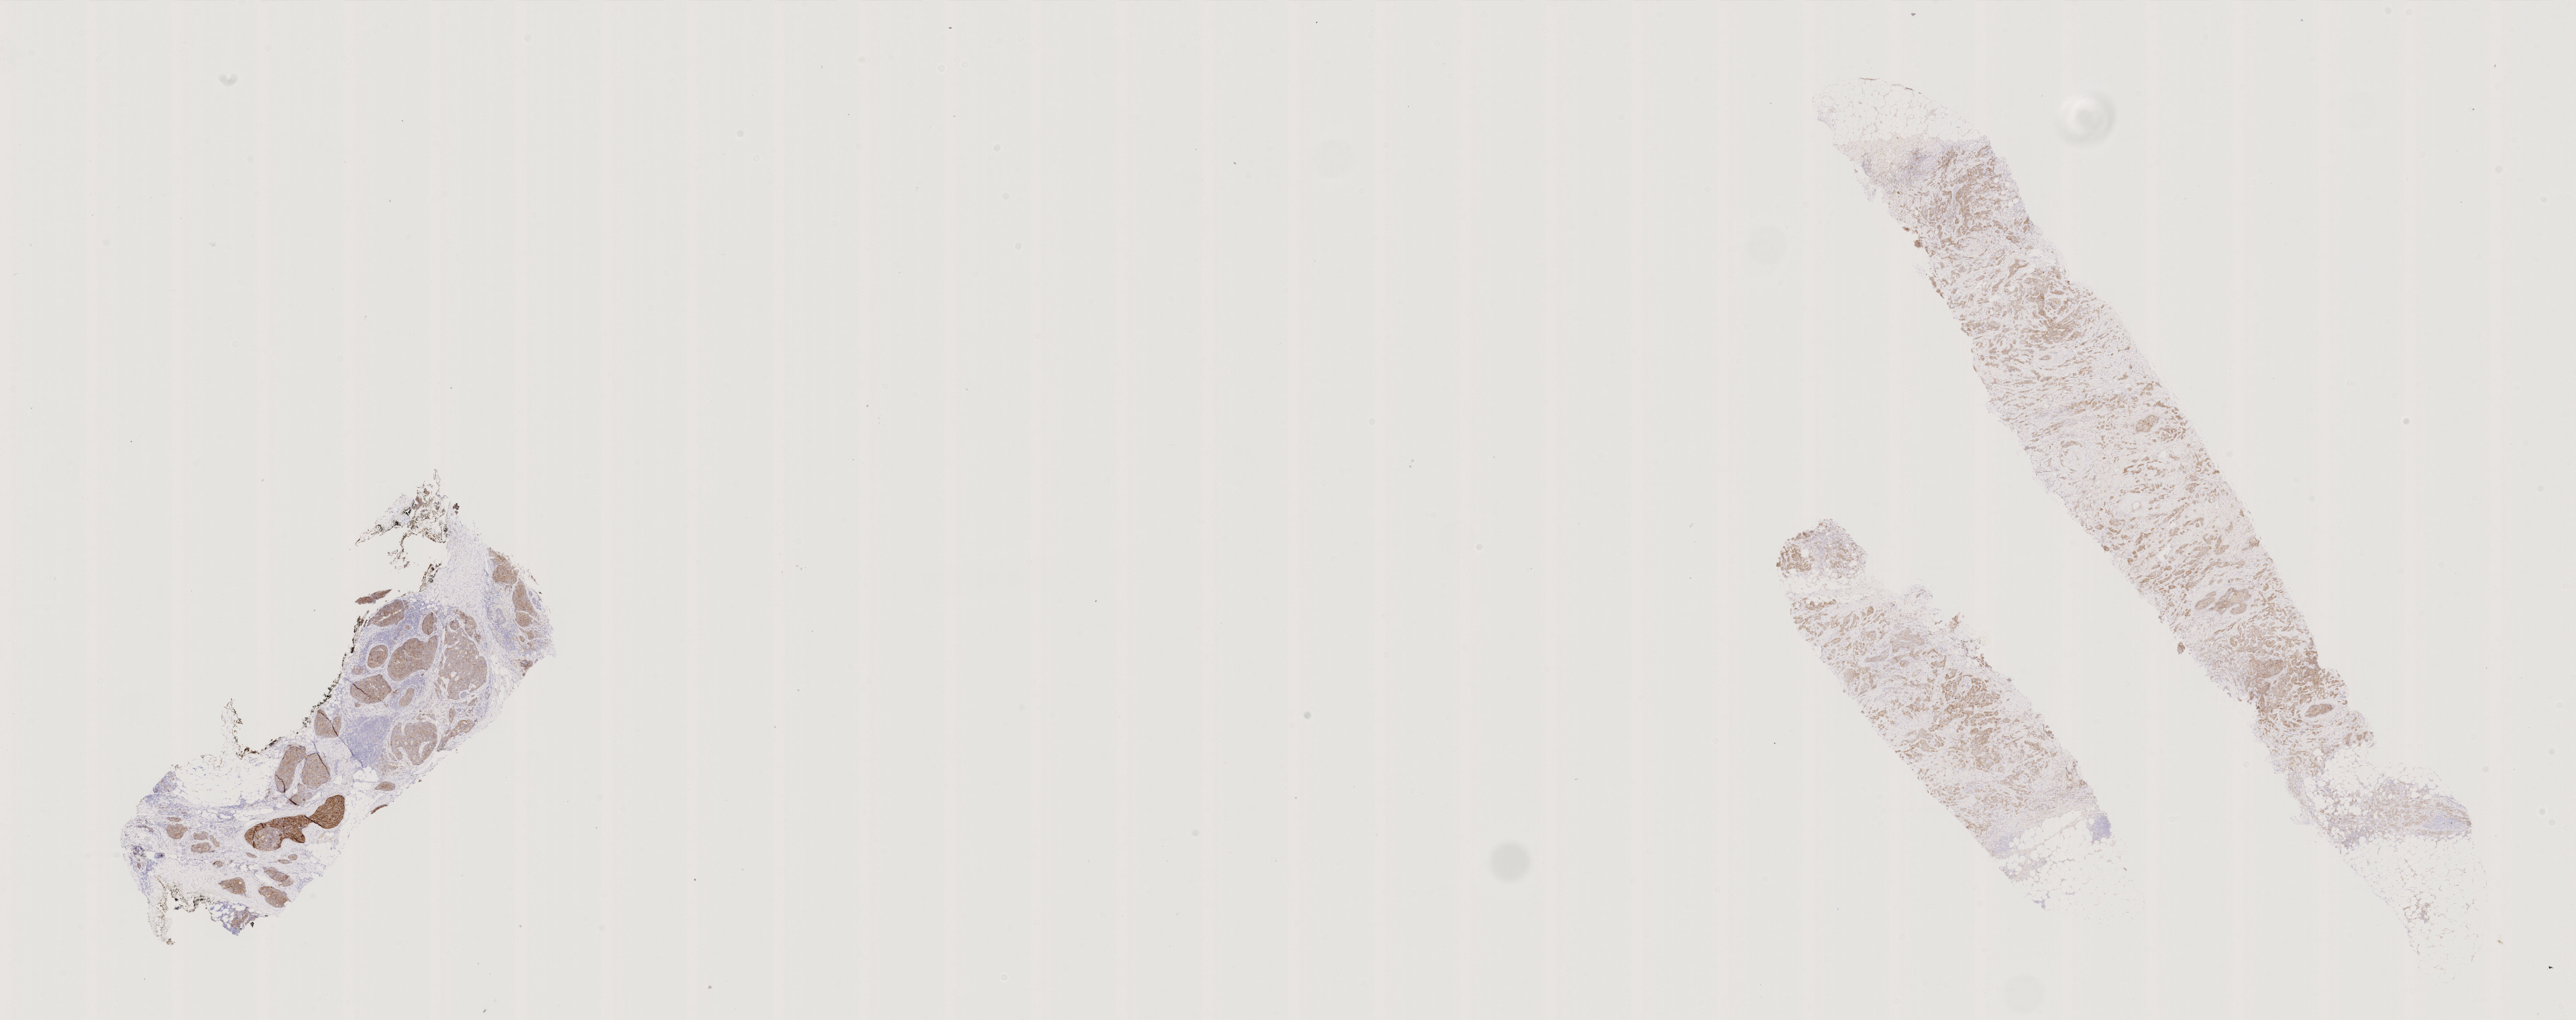

In [129]:
img_IHC.read_region((0,0),5,img_IHC.level_dimensions[5])